In [19]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

from skimage.measure import marching_cubes
import trimesh
import trimesh.smoothing
import os

In [20]:
print("torch version: ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")

print("device: ", device)

torch version:  2.5.1
device:  mps


In [23]:
import numpy as np
import os
import imageio.v2 as imageio
from typing import Dict, Tuple
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def read_cameras(path: str) -> Dict:
    cameras = {}
    with open(path, "r") as f:
        for line in f:
            if line[0] == "#": continue
            data = line.strip().split()
            camera_id = int(data[0])
            cameras[camera_id] = {
                "model": data[1],
                "width": int(data[2]),
                "height": int(data[3]),
                "params": np.array(data[4:], dtype=np.float64)
            }
    return cameras

def read_images(path: str) -> Dict:
    images = {}
    with open(path, "r") as f:
        lines = f.readlines()

    for i in range(0, len(lines), 2):
        if lines[i][0] == "#": continue
        data = lines[i].split()
        points_data = lines[i + 1].split()
        
        image_id = int(data[0])
        images[image_id] = {
            "qvec": np.array(data[1:5], dtype=float),
            "tvec": np.array(data[5:8], dtype=float),
            "camera_id": int(data[8]),
            "name": data[9],
            "xys": np.array([(float(points_data[j]), float(points_data[j+1])) 
                           for j in range(0, len(points_data), 3)]),
            "point3D_ids": np.array([int(points_data[j+2]) 
                                   for j in range(0, len(points_data), 3)])
        }
    return images

def qvec2rotmat(qvec: np.ndarray) -> np.ndarray:
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def generate_rays(camera: Dict, image_data: Dict, img: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Keep original dimensions
    H, W = img.shape[:2]
    f = camera['params'][0]
        
    if img.shape[2] == 4:
        img = img[..., :3] * img[..., -1:] + (1 - img[..., -1:])
    
    R = qvec2rotmat(image_data['qvec'])
    t = image_data['tvec']
    C = -R.T @ t
    
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    dirs = np.stack([(u - W/2), -(v - H/2), -np.ones_like(u) * f], axis=-1)
    dirs = (R.T @ dirs.reshape(-1, 3).T).T
    dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
    
    rays_o = np.broadcast_to(C, dirs.shape)
    rays_d = dirs
    target_px_values = img.reshape(-1, 3)
    
    return rays_o, rays_d, target_px_values

def get_rays(datapath: str, mode: str = 'train') -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    colmap_dir = os.path.join(datapath, 'colmap')
    imgs_dir = os.path.join(datapath, 'imgs')
    
    cameras = read_cameras(os.path.join(colmap_dir, 'cameras.txt'))
    images = read_images(os.path.join(colmap_dir, 'images.txt'))
    
    # Get a sample image to determine dimensions
    sample_img = imageio.imread(os.path.join(imgs_dir, list(images.values())[0]['name']))
    H, W = sample_img.shape[:2]
    
    image_list = sorted(images.items(), key=lambda x: x[1]['name'])
    split_idx = int(len(image_list) * 0.9)
    selected_images = image_list[:split_idx] if mode == 'train' else image_list[split_idx:]
    
    rays_o = []
    rays_d = []
    target_px_values = []
    
    for image_id, image_data in selected_images:
        img_path = os.path.join(imgs_dir, image_data['name'])
        img = imageio.imread(img_path).astype(np.float32) / 255.0
        
        # Ensure consistent dimensions
        if img.shape[:2] != (H, W):
            from skimage.transform import resize
            img = resize(img, (H, W, 3), anti_aliasing=True)
        
        camera = cameras[image_data['camera_id']]
        ro, rd, rgb = generate_rays(camera, image_data, img)
        
        rays_o.append(ro)
        rays_d.append(rd)
        target_px_values.append(rgb)
    
    # Stack and reshape
    rays_o = np.stack(rays_o)
    rays_d = np.stack(rays_d)
    target_px_values = np.stack(target_px_values)
    
    n_images = len(selected_images)
    logger.info(f"Number of images: {n_images}, Image dimensions: {H}x{W}")
    
    return (rays_o.reshape(n_images, H, W, 3),
            rays_d.reshape(n_images, H, W, 3),
            target_px_values.reshape(n_images, H, W, 3))

# Camera / Dataset

In [25]:
batch_size = 1024
o, d, target_px_values = get_rays('fox', mode='train')

# Regular dataloader
dataloader = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(-1, 3).type(torch.float),
    torch.from_numpy(d).reshape(-1, 3).type(torch.float),
    torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
    batch_size=batch_size, shuffle=True)

# Warmup dataloader with cropped center region
dataloader_warmup = DataLoader(torch.cat((
    torch.from_numpy(o).reshape(89, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
    torch.from_numpy(d).reshape(89, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
    torch.from_numpy(target_px_values).reshape(89, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
    batch_size=batch_size, shuffle=True)

# Test data
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

INFO:__main__:Number of images: 89, Image dimensions: 400x400
INFO:__main__:Number of images: 10, Image dimensions: 400x400


# Training

100%|███████████████████████████████████████| 3477/3477 [10:33<00:00,  5.49it/s]


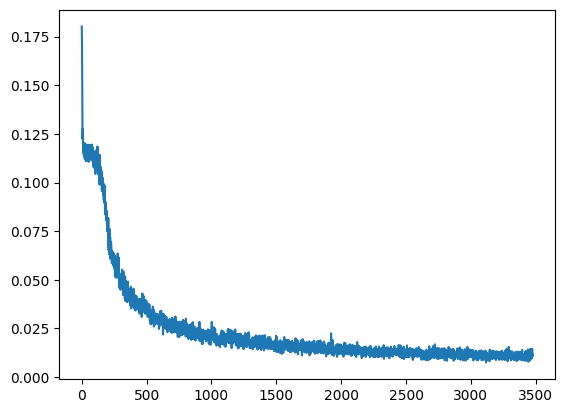

100%|█████████████████████████████████████| 13907/13907 [42:13<00:00,  5.49it/s]


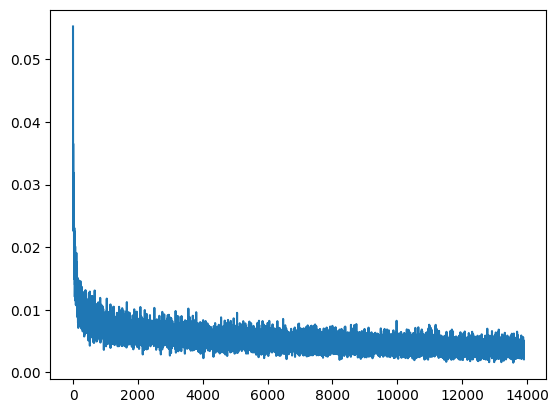

In [26]:
device = device

tn = 8.
tf = 12.
nb_epochs = 1 #15 30
lr =  1e-3 # 1e-3 5e-4
gamma = .5 #0.5 0.7 
nb_bins = 100 #100 256

model = Nerf(hidden_dim=256).to(device) #Nerf(hidden_dim=128).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [27]:
torch.save(model, 'model_nerf_colmap')

# Mesh extraction

In [28]:
model = torch.load('model_nerf_colmap').to(device)

/var/folders/wv/_x9hjmys03x5gnbfl70ry2sr0000gn/T/ipykernel_19348/2503494064.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_nerf_colmap').to(de

In [29]:
import torch
import numpy as np
from skimage.measure import marching_cubes
import trimesh
import torch.nn.functional as F

def analyze_density_field(density_volume):
    """Analyze the density field to help choose a good threshold."""
    min_density = float(density_volume.min())
    max_density = float(density_volume.max())
    mean_density = float(density_volume.mean())
    std_density = float(density_volume.std())
    
    print(f"Density field statistics:")
    print(f"Min: {min_density:.6f}")
    print(f"Max: {max_density:.6f}")
    print(f"Mean: {mean_density:.6f}")
    print(f"Std: {std_density:.6f}")
    
    # Suggest threshold as mean + 1 std deviation
    suggested_threshold = mean_density + std_density
    return suggested_threshold

def extract_mesh(nerf_model, resolution=128, threshold=None, bbox_min=[-1.5, -1.5, -1.5], 
                bbox_max=[1.5, 1.5, 1.5], device=torch.device("cpu")):
    """
    Extract a colored mesh from a trained NeRF model.
    
    Args:
        nerf_model: Trained NeRF model
        resolution: Grid resolution for marching cubes
        threshold: Density threshold for surface extraction (if None, will be auto-determined)
        bbox_min: Minimum corner of bounding box
        bbox_max: Maximum corner of bounding box
        device: Torch device to use
    
    Returns:
        trimesh.Trimesh: Colored mesh
    """
    print(f"Creating density volume with resolution {resolution}...")
    
    # Create grid of points
    x = torch.linspace(bbox_min[0], bbox_max[0], resolution)
    y = torch.linspace(bbox_min[1], bbox_max[1], resolution)
    z = torch.linspace(bbox_min[2], bbox_max[2], resolution)
    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    points = torch.stack([xx, yy, zz], dim=-1).to(device)
    
    # Create density volume
    density_volume = torch.zeros((resolution, resolution, resolution))
    chunk_size = 512 * 512  # Process in chunks to avoid OOM
    
    print("Sampling density field...")
    with torch.no_grad():
        for i in range(0, points.numel() // 3, chunk_size):
            chunk_points = points.reshape(-1, 3)[i:i+chunk_size]
            # Assume model returns (rgb, sigma) tuple
            _, chunk_densities = nerf_model(chunk_points, torch.zeros_like(chunk_points))
            density_volume.reshape(-1)[i:i+chunk_size] = chunk_densities.cpu()
    
    # Auto-determine threshold if not provided
    if threshold is None:
        threshold = analyze_density_field(density_volume)
        print(f"Auto-determined threshold: {threshold:.6f}")
    
    print(f"Extracting mesh with threshold {threshold}...")
    
    try:
        # Extract mesh using marching cubes
        vertices, faces, normals, _ = marching_cubes(
            density_volume.numpy(),
            threshold,
            spacing=((bbox_max[0] - bbox_min[0])/resolution,
                    (bbox_max[1] - bbox_min[1])/resolution,
                    (bbox_max[2] - bbox_min[2])/resolution)
        )
    except ValueError as e:
        print("Error during marching cubes:")
        print(e)
        print("\nTry adjusting the threshold based on the density statistics above.")
        raise
    
    print(f"Mesh extracted with {len(vertices)} vertices and {len(faces)} faces")
    
    # Adjust vertices to match bbox
    vertices = vertices + np.array(bbox_min)
    
    # Sample colors at vertex positions
    vertex_colors = torch.zeros((len(vertices), 3))
    vertices_tensor = torch.tensor(vertices, dtype=torch.float32).to(device)
    
    print("Sampling colors...")
    with torch.no_grad():
        for i in range(0, len(vertices), chunk_size):
            chunk_vertices = vertices_tensor[i:i+chunk_size]
            # Assume model returns (rgb, sigma) tuple
            chunk_colors, _ = nerf_model(chunk_vertices, torch.zeros_like(chunk_vertices))
            vertex_colors[i:i+chunk_size] = chunk_colors.cpu()
    
    # Create mesh with vertex colors
    mesh = trimesh.Trimesh(
        vertices=vertices,
        faces=faces,
        vertex_colors=(vertex_colors.numpy() * 255).astype(np.uint8),
        vertex_normals=normals
    )
    
    return mesh

def save_colored_mesh(nerf_model, output_path, resolution=256, threshold=None, device=torch.device("cpu")):
    """
    Extract and save a colored mesh from a NeRF model.
    
    Args:
        nerf_model: Trained NeRF model
        output_path: Path to save the mesh (should end in .ply or .obj)
        resolution: Resolution for marching cubes
        threshold: Density threshold (if None, will be auto-determined)
        device: Torch device to use
    """
    mesh = extract_mesh(nerf_model, resolution=resolution, threshold=threshold, device=device)
    
    print("Processing mesh...")
    # Optional mesh cleanup
    mesh = mesh.process(validate=True)
    
    print(f"Saving mesh to {output_path}...")
    # Save the mesh
    mesh.export(output_path)
    return mesh

# After loading your model
resolution = 700  # Increase for better quality, decrease if you run into memory issues
output_path = "nerf_mesh.obj"  # Can also use .obj format

# Extract and save the mesh
mesh = save_colored_mesh(model, output_path, resolution=resolution, device=device)

Creating density volume with resolution 700...
Sampling density field...
Density field statistics:
Min: 0.000000
Max: 298.032959
Mean: 28.803631
Std: 31.250738
Auto-determined threshold: 60.054369
Extracting mesh with threshold 60.05436897277832...
Mesh extracted with 17831979 vertices and 35505693 faces
Sampling colors...
Processing mesh...
Saving mesh to nerf_mesh.obj...


In [ ]:
#!pip install Pymcubes
#!pip install trimesh
#!pip install -U scikit-image
#!pip install genesis-world  # Requires Python >=3.9;
#!pip uninstall genesis-world
#!conda install -c anaconda trimesh